In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import cv2
from PIL import Image
from evaluation.neuroprobe.config import ROOT_DIR, SAMPLING_RATE
from subject.braintreebank import BrainTreebankSubject
import pandas as pd
import math
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import pearsonr
from matplotlib.lines import Line2D

SUBJECT_TRIAL_TO_MOVIE = {
    (1,0): 'fantastic-mr-fox.mp4',
    (1,1): 'the-martian.mp4',
    (1,2): 'thor-ragnarok.mp4',
    (2,0): 'venom.mp4',
    (2,1): 'spider-man-3-homecoming.mp4',
    (2,2): 'guardians-of-the-galaxy.mp4',
    (2,3): 'guardians-of-the-galaxy-2.mp4',
    (2,4): 'avengers-infinity-war.mp4',
    (2,5): 'black-panther.mp4',
    (2,6): 'aquaman.mp4',
    (3,0): 'cars-2.mp4',
    (3,1): 'lotr-1.mp4',
    (3,2): 'lotr-2.mp4',
    (4,0): 'shrek-the-third.mp4',
    (4,1): 'megamind.mp4',
    (4,2): 'incredibles.mp4',
    (5,0): 'fantastic-mr-fox.mp4',
    (6,0): 'megamind.mp4',
    (6,1): 'toy-story.mp4',
    (6,2): 'coraline.mp4',
    (7,0): 'cars-2.mp4',
    (7,1): 'megamind.mp4',
    (8,0): 'sesame-street-episode-3990.mp4',
    (9,0): 'ant-man.mp4',
    (10,0): 'cars-2.mp4',
    (10,1): 'spider-man-far-from-home.mp4',
}

CLIP_DIR = "/om2/data/public/braintreebank_movies_clip_preprocessed_2/"
MOVIES_DIR = "/om2/data/public/braintreebank_movies/"

In [2]:
def extract_frame_at_time(video_path, timestamp):
    """
    Extract a frame from video at a specific timestamp.
    
    Args:
        video_path (str): Path to the video file
        timestamp (float): Timestamp in seconds
    Returns:
        PIL.Image: The extracted frame as PIL Image
    """
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_number = int(timestamp * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Warning: Could not extract frame at timestamp {timestamp}")
        return None
    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    return pil_image


def obtain_neural_data_index(sub_id, trial_id, movie_times):
    # Data frames column IDs
    start_col, end_col = 'start', 'end'
    trig_time_col, trig_idx_col, est_idx_col, est_end_idx_col = 'movie_time', 'index', 'est_idx', 'est_end_idx'

    # Path to trigger times csv file
    trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{sub_id}_trial{trial_id:03}_timings.csv')

    trigs_df = pd.read_csv(trigger_times_file)
    # display(trigs_df.head())

    last_t = trigs_df[trig_time_col].iloc[-1]
    assert np.all(movie_times < last_t), "Movie times must be less than the last trigger time"
    
    # Vectorized nearest trigger finding
    start_indices = np.searchsorted(trigs_df[trig_time_col].values, movie_times)
    start_indices = np.maximum(start_indices, 0) # handle the edge case where movie starts right at the word
    
    # Vectorized sample index calculation
    return np.round(
        trigs_df.loc[start_indices, trig_idx_col].values + 
        (movie_times - trigs_df.loc[start_indices, trig_time_col].values) * SAMPLING_RATE
    ).astype(int)

def get_neural_data_at_index(subject_id, trial_id, electrode, start, end):
    subject = BrainTreebankSubject(subject_id, cache=False)
    neural_data = subject.get_electrode_data(electrode,trial_id,window_from=start, window_to=end)
    return neural_data

In [3]:
def get_movie_data(movie):
    clip_features_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_clip_features.npy'))
    timestamps_path = os.path.join(CLIP_DIR, movie.replace('.mp4', '_timestamps.npy'))
    movie_path = os.path.join(MOVIES_DIR, movie)

    clip_features = np.load(clip_features_path)  # shape: (num_samples, feature_dim)
    timestamps = np.load(timestamps_path)
    return clip_features, timestamps, movie_path

def get_subject_trial_from_movie(movie):
    subject_trial_list = []
    for subject_trial, movie_name in SUBJECT_TRIAL_TO_MOVIE.items():
        if movie_name == movie:
            subject_trial_list.append(subject_trial)
    return subject_trial_list

def get_unique_electrodes(electrode_locations):
    unique_electrodes = {}
    seen_values = set()
    
    for key, value in electrode_locations.items():
        if value not in seen_values:
            unique_electrodes[key] = value
            seen_values.add(value)
    
    return list(unique_electrodes.keys())

In [4]:
movie = 'ant-man.mp4'
clip_features, timestamps, movie_path = get_movie_data(movie)

subject_trial_list = get_subject_trial_from_movie(movie)
subject_id, trial_id = subject_trial_list[0]
subject = BrainTreebankSubject(subject_id, cache=False)
electrode_locations = {electrode_label: subject.get_electrode_metadata(electrode_label)['DesikanKilliany'] for electrode_label in subject.get_electrode_labels()}
unique_electrodes = electrode_locations.keys()

trigger_times_file = os.path.join(ROOT_DIR, f'subject_timings/sub_{subject_id}_trial{trial_id:03}_timings.csv')
trigs_df = pd.read_csv(trigger_times_file)
last_trigger_time = trigs_df['movie_time'].iloc[-1]
safe_end_timestamp = min(timestamps[-2], last_trigger_time - 1.0)  # 1 second buffer

sampled_times = np.arange(0, safe_end_timestamp, 1.0)
sampled_indices = obtain_neural_data_index(subject_id, trial_id, sampled_times)

# start_idx = obtain_neural_data_index(subject_id, trial_id, np.array([0])).item()
# end_idx = obtain_neural_data_index(subject_id, trial_id, np.array([safe_end_timestamp])).item()
# neural_data = subject.get_all_electrode_data(trial_id, window_from=start_idx, window_to=end_idx)

# neural_data.shape

sampled_indices

array([ 372476,  373750,  374791, ..., 7113801, 7114839, 7115863])

In [5]:
# Find the indices in `timestamps` that are closest to each value in `sampled_times`
timestamp_indices = np.searchsorted(timestamps, sampled_times, side="left")
timestamp_indices

array([     0,     24,     48, ..., 154861, 154885, 154909])

In [6]:
window_ms = 250

# electrode_label = list(unique_electrodes)[1]
electrode_label = 'P2e8'
windowed_neural_data = []

for t in tqdm(sampled_times):
    window_start = t - window_ms / 1000
    window_end = t + window_ms / 1000

    idx_start = obtain_neural_data_index(subject_id, trial_id, np.array([window_start])).item()
    # idx_end = obtain_neural_data_index(subject_id, trial_id, np.array([window_end])).item() + 1  # +1 for inclusive window
    idx_end = int(idx_start + 0.75 * 2048)

    data = subject.get_electrode_data(electrode_label, trial_id, window_from=idx_start, window_to=idx_end)
    windowed_neural_data.append(data.cpu().numpy() if hasattr(data, "cpu") else data)

# Pad shorter windows to match the longest one
# max_length = max(len(w) for w in windowed_neural_data)
# padded_data = [np.pad(w, (0, max_length - len(w)), mode='constant') for w in windowed_neural_data]
y = np.stack(windowed_neural_data)


X = clip_features[timestamp_indices]

# Split into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y, sampled_times, test_size=0.2, random_state=42
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6462/6462 [06:54<00:00, 15.57it/s]


In [7]:
X.shape

(6462, 512)

In [8]:
y.shape

(6462, 1536)

In [9]:
y_copy = y.copy()

# AVERAGE
y_avg = np.mean(y_copy, axis=1)
y_avg.shape

X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(
    X, y_avg, sampled_times, test_size=0.2, random_state=42
)

In [10]:
from model.electrode_embedding import ElectrodeEmbedding_Learned, ElectrodeEmbedding_NoisyCoordinate, ElectrodeEmbedding_Learned_CoordinateInit, ElectrodeEmbedding_Zero
from model.preprocessing.laplacian_rereferencing import laplacian_rereference_batch
from training_setup.training_config import log
import torch
from training_setup.training_setup import TrainingSetup
from model.BFModule import BFModule
from model.transformer_implementation import Transformer
import torch.nn as nn
from training_setup.training_config import get_default_config

class SpectrogramPreprocessor(BFModule):
    def __init__(self, spectrogram_parameters=None, output_dim=-1):
        """
        spectrogram_parameters is a dictionary with the following keys:
        spectrogram_parameters = {
            'max_frequency': int, 'Maximum frequency for spectrogram'
            'tperseg': float, 'Time of each spectrogram segment in seconds'
            'poverlap': float, 'Proportion of overlap between segments for spectrogram'
            'window': str, 'Window function for spectrogram', # Allowed values: 'hann', 'boxcar'
        }
        """
        if spectrogram_parameters is None: # Load default spectrogram parameters from training config
            spectrogram_parameters = get_default_config(random_string="TEMP", wandb_project="")['model']['signal_preprocessing']['spectrogram_parameters']

        super(SpectrogramPreprocessor, self).__init__()
        self.output_dim = output_dim
        self.spectrogram_parameters = spectrogram_parameters
        
        # from https://docs.pytorch.org/docs/stable/generated/torch.fft.rfftfreq.html
        # if n is nperseg, and d is 1/sampling_rate, then f = torch.arange((n + 1) // 2) / (d * n)
        # note: nperseg is always going to be even, so it simplifies to torch.arange(n/2) / n * sampling_rate
        # note: n = sampling_rate * tperseg, so it simplifies to torch.arange(sampling_rate * tperseg / 2) / tperseg
        #    which is a list that goes from 0 to sampling_rate / 2 in increments of sampling_rate / nperseg = 1 / tperseg
        # so max frequency bin is max_frequency * tperseg + 1 (adding one to make the endpoint inclusive)
        self.max_frequency_bin = round(self.spectrogram_parameters['max_frequency'] * self.spectrogram_parameters['tperseg'] + 1)

        # Transform FFT output to match expected output dimension
        self.output_transform = nn.Identity() if self.output_dim == -1 else nn.Linear(self.max_frequency_bin, self.output_dim)
    
    def forward(self, batch):
        # batch['data'] is of shape (batch_size, n_electrodes, n_samples)
        # batch['metadata'] is a dictionary containing metadata like the subject identifier and trial id, sampling rate, etc.
        batch_size, n_electrodes = batch['data'].shape[:2]
        
        # Reshape for STFT
        x = batch['data'].reshape(batch_size * n_electrodes, -1)
        x = x.to(dtype=torch.float32)  # Convert to float32 for STFT
        
        # STFT parameters
        sampling_rate = batch['metadata']['sampling_rate']
        nperseg = round(self.spectrogram_parameters['tperseg'] * sampling_rate)
        noverlap = round(self.spectrogram_parameters['poverlap'] * nperseg)
        hop_length = nperseg - noverlap
        
        window = {
            'hann': torch.hann_window,
            'boxcar': torch.ones,
        }[self.spectrogram_parameters['window']](nperseg, device=x.device)
        
        # Compute STFT
        x = torch.stft(x,
                      n_fft=nperseg, 
                      hop_length=hop_length,
                      win_length=nperseg,
                      window=window,
                      return_complex=True,
                      normalized=False,
                      center=True)
        
        # Take magnitude
        x = torch.abs(x)

        # Trim to max frequency (using a pre-calculated max frequency bin)
        x = x[:, :self.max_frequency_bin, :]
            
        # Reshape back
        _, n_freqs, n_times = x.shape
        x = x.reshape(batch_size, n_electrodes, n_freqs, n_times)
        x = x.transpose(2, 3) # (batch_size, n_electrodes, n_timebins, n_freqs)
        
        # Z-score normalization
        x = x - x.mean(dim=[0, 2], keepdim=True)
        x = x / (x.std(dim=[0, 2], keepdim=True) + 1e-5)

        freq_bins = torch.fft.rfftfreq(nperseg, d=1/sampling_rate)
        freq_bins = freq_bins[:self.max_frequency_bin]

        n_timebins = x.shape[2]
        time_bins = torch.arange(n_timebins, device=x.device) * hop_length / sampling_rate


        return x.to(dtype=batch['data'].dtype), freq_bins, time_bins

In [11]:
y_copy.shape

(6462, 1536)

In [12]:

y_tensor = torch.tensor(y_copy)
y_tensor = y_tensor.reshape(y_copy.shape[0], 1, y_copy.shape[1])
print(y_tensor.shape)

nperseg = 400
noverlap = 350
tperseg = nperseg / 2048
poverlap = noverlap / nperseg
spec_preproc = SpectrogramPreprocessor({'max_frequency': 200, 'window': 'hann', 'tperseg': tperseg, 'poverlap': poverlap})
y_spectrogram, freq_bins, time_bins = spec_preproc({'data': y_tensor, 'metadata': {'sampling_rate': 2048}})  # shape: (batch_size, n_electrodes, n_timebins, n_freqs)

freq_bin_edges = {
    'delta': (0, 4),    # 0-20 Hz (bins 0-3)
    'theta': (4, 8),    # 20-40 Hz (bins 4-7)
    'alpha': (8, 12),   # 40-60 Hz (bins 8-11)
    'beta': (12, 30),   # 60-150 Hz (bins 12-29)
    'gamma': (30, 40),  # 150-200 Hz (bins 30-39)
}

y_band_dict = {}
for band, (start, end) in freq_bin_edges.items():
    # Average across the frequency bins for each band
    y_band_dict[band] = y_spectrogram[..., start:end].mean(dim=-1)  # shape: (batch_size, n_electrodes, n_timebins)

# Now y_band_dict contains the neural data averaged in each frequency band
# Example: y_band_dict['alpha'] is the alpha band neural activity
y_band_dict['alpha'].shape

torch.Size([6462, 1, 1536])


torch.Size([6462, 1, 31])

In [13]:
y_spectrogram.shape

torch.Size([6462, 1, 31, 40])

In [14]:
freq_bins

tensor([  0.0000,   5.1200,  10.2400,  15.3600,  20.4800,  25.6000,  30.7200,
         35.8400,  40.9600,  46.0800,  51.2000,  56.3200,  61.4400,  66.5600,
         71.6800,  76.8000,  81.9200,  87.0400,  92.1600,  97.2800, 102.4000,
        107.5200, 112.6400, 117.7600, 122.8800, 128.0000, 133.1200, 138.2400,
        143.3600, 148.4800, 153.6000, 158.7200, 163.8400, 168.9600, 174.0800,
        179.2000, 184.3200, 189.4400, 194.5600, 199.6800])

In [15]:
time_bins

tensor([0.0000, 0.0244, 0.0488, 0.0732, 0.0977, 0.1221, 0.1465, 0.1709, 0.1953,
        0.2197, 0.2441, 0.2686, 0.2930, 0.3174, 0.3418, 0.3662, 0.3906, 0.4150,
        0.4395, 0.4639, 0.4883, 0.5127, 0.5371, 0.5615, 0.5859, 0.6104, 0.6348,
        0.6592, 0.6836, 0.7080, 0.7324])

Timebin:   0%|                                                                                                                                        | 0/31 [00:00<?, ?it/s]

Timebin: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [09:23<00:00, 18.17s/it]


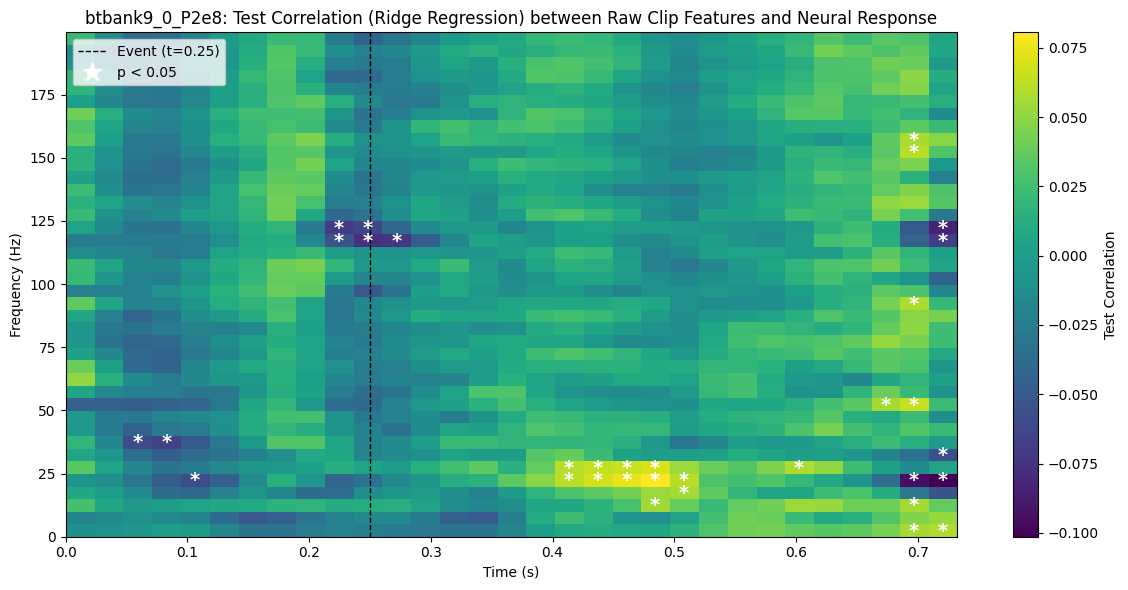

In [17]:
from sklearn.preprocessing import StandardScaler

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

correlation_matrix = np.zeros((n_freqs, n_timebins))
test_correlation_matrix = np.zeros((n_freqs, n_timebins))
test_pval_matrix = np.zeros((n_freqs, n_timebins))

from sklearn.cross_decomposition import PLSRegression

n_samples = X.shape[0]
# Use consecutive points for train and test: first 80% train, last 20% test
split_idx = int(n_samples * 0.8)
train_idx = np.arange(0, split_idx)
test_idx = np.arange(split_idx, n_samples)

# Fit scaler on training data only, apply to both train and test
scaler = StandardScaler()
X_train = X[train_idx]
X_test = X[test_idx]
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = min(20, X_train_scaled.shape[1])  # You can adjust n_components as needed

for t in tqdm(range(n_timebins), desc="Timebin"):
    for f in range(n_freqs):
        # Get the neural response for all samples at this (t, f)
        y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
        y_train, y_test = y_vals[train_idx], y_vals[test_idx]
        # PLSRegression expects 2D y, so reshape
        y_train_2d = y_train.reshape(-1, 1)
        pls = PLSRegression(n_components=n_components)
        pls.fit(X_train_scaled, y_train_2d)
        y_pred_test = pls.predict(X_test_scaled).ravel()
        corr, pval = pearsonr(y_test, y_pred_test)
        test_correlation_matrix[f, t] = corr
        test_pval_matrix[f, t] = pval

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0],
        time_bins[-1],
        freq_bins[0],
        freq_bins[-1]
    ]
)

star_y, star_x = np.where(test_pval_matrix < 0.05)

time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=14, ha='center', va='center', fontweight='bold'
    )

event_time = 0.25
event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response')
plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


Timebin: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:15<00:00,  6.30s/it]


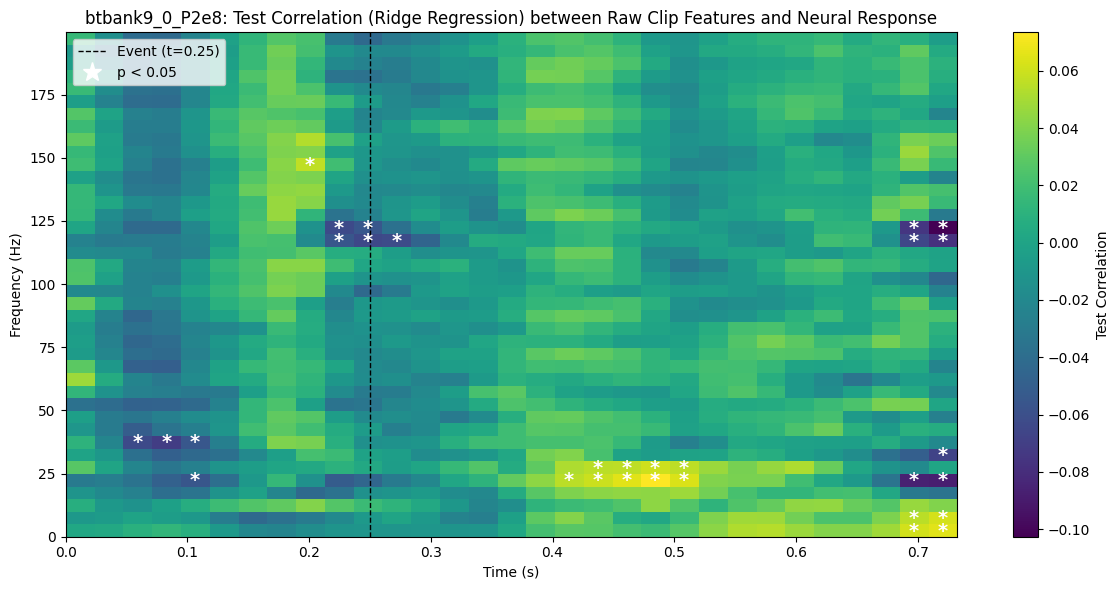

In [28]:
from sklearn.preprocessing import StandardScaler

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

correlation_matrix = np.zeros((n_freqs, n_timebins))
test_correlation_matrix = np.zeros((n_freqs, n_timebins))
test_pval_matrix = np.zeros((n_freqs, n_timebins))

n_samples = X.shape[0]
# Use consecutive points for train and test: first 80% train, last 20% test
split_idx = int(n_samples * 0.8)
train_idx = np.arange(0, split_idx)
test_idx = np.arange(split_idx, n_samples)

# Fit scaler on training data only, apply to both train and test
scaler = StandardScaler()
X_train = X[train_idx]
X_test = X[test_idx]
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

for t in tqdm(range(n_timebins), desc="Timebin"):
    for f in range(n_freqs):
        # Get the neural response for all samples at this (t, f)
        y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
        y_train, y_test = y_vals[train_idx], y_vals[test_idx]
        reg = Ridge(alpha=0.1)
        reg.fit(X_train_scaled, y_train)
        y_pred_test = reg.predict(X_test_scaled)
        corr, pval = pearsonr(y_test, y_pred_test)
        test_correlation_matrix[f, t] = corr
        test_pval_matrix[f, t] = pval

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0],
        time_bins[-1],
        freq_bins[0],
        freq_bins[-1]
    ]
)

star_y, star_x = np.where(test_pval_matrix < 0.05)

time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=14, ha='center', va='center', fontweight='bold'
    )

event_time = 0.25
event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response')
plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
plt.tight_layout()
plt.show()



=== Results for Ridge alpha=0.05 ===


Timebin (alpha=0.05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:17<00:00,  6.36s/it]


Test Correlation Matrix (shape (40, 31)):
[[-0.00516375 -0.00391607  0.00143273 ...  0.05225626  0.06520899
   0.06883594]
 [-0.01606462 -0.01360734 -0.0064808  ...  0.04037851  0.05746524
   0.06359657]
 [ 0.021943    0.00247981 -0.00667999 ...  0.03591174  0.06083328
   0.04759898]
 ...
 [-0.01342092 -0.03075449 -0.03941482 ...  0.02941144  0.03461344
   0.00579547]
 [-0.01237784 -0.0410559  -0.04318457 ...  0.0163073   0.02711955
   0.00066484]
 [ 0.01661312 -0.01541129 -0.03976716 ...  0.02186308  0.0176443
  -0.00055935]]
Test P-value Matrix (shape (40, 31)):
[[0.85283586 0.88812305 0.95895189 ... 0.06031101 0.01902538 0.01329503]
 [0.56384816 0.62495052 0.81590457 ... 0.14674352 0.03882264 0.02219998]
 [0.43048333 0.92901545 0.81035247 ... 0.1968796  0.02871537 0.08710083]
 ...
 [0.62970044 0.26912873 0.15663795 ... 0.29060674 0.21356958 0.83507645]
 [0.65655616 0.14007946 0.12064639 ... 0.5579732  0.32985344 0.98094554]
 [0.55061208 0.57981106 0.15296342 ... 0.4321646  0.5261494

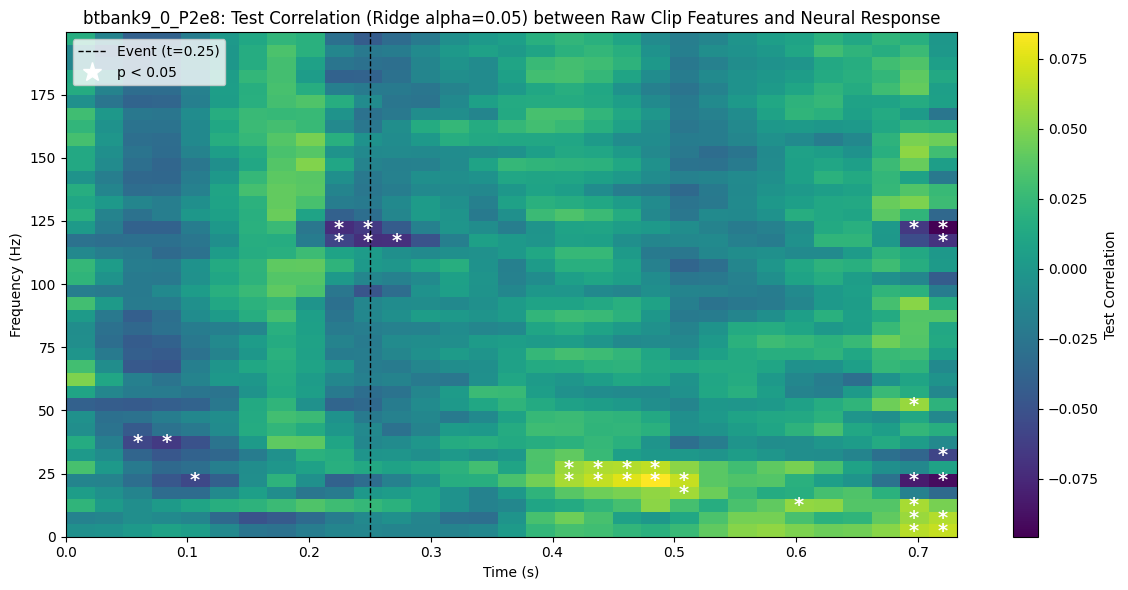


=== Results for Ridge alpha=0.1 ===


Timebin (alpha=0.1): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:26<00:00,  6.65s/it]


Test Correlation Matrix (shape (40, 31)):
[[-0.00489446 -0.00372647  0.00118624 ...  0.05409216  0.06719431
   0.07097277]
 [-0.01675444 -0.01447918 -0.0068514  ...  0.04112271  0.05846093
   0.0645754 ]
 [ 0.024555    0.00549118 -0.0029956  ...  0.04262779  0.06819184
   0.05042016]
 ...
 [-0.01668209 -0.032087   -0.03820588 ...  0.03330068  0.03666567
   0.00126135]
 [-0.01280455 -0.04155132 -0.0416102  ...  0.01865437  0.02450204
  -0.00646608]
 [ 0.01726767 -0.01423149 -0.03766005 ...  0.02493796  0.02184607
   0.00033937]]
Test P-value Matrix (shape (40, 31)):
[[0.8604297  0.8935067  0.96600925 ... 0.05182251 0.01566671 0.01068571]
 [0.54722673 0.60294473 0.8055822  ... 0.13943505 0.03556019 0.02022215]
 [0.37764961 0.84362078 0.91430295 ... 0.12551324 0.01418488 0.06992088]
 ...
 [0.54895858 0.24892059 0.16975505 ... 0.23145868 0.18763649 0.96385863]
 [0.64551368 0.13535476 0.13480146 ... 0.50273729 0.37867946 0.8163153 ]
 [0.53501945 0.60916115 0.17593993 ... 0.37025341 0.432522

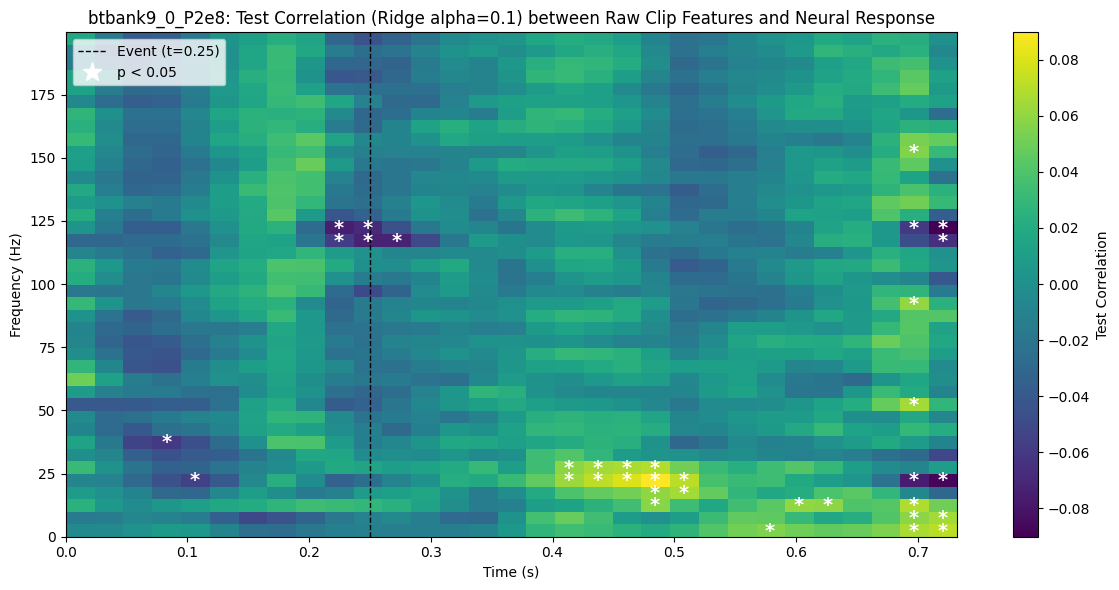


=== Results for Ridge alpha=0.5 ===


Timebin (alpha=0.5): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:19<00:00,  6.45s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.00438292  0.00491594  0.00732861 ...  0.05774804  0.0710145
   0.07523044]
 [-0.01318636 -0.01328096 -0.00621958 ...  0.04227159  0.05962122
   0.06536427]
 [ 0.0297905   0.01195153  0.00757354 ...  0.06081098  0.08681756
   0.05797539]
 ...
 [-0.0249934  -0.03520735 -0.03548435 ...  0.0392146   0.03981612
  -0.00648134]
 [-0.01217897 -0.04122901 -0.0377613  ...  0.01987501  0.01807296
  -0.02430586]
 [ 0.01552664 -0.01200123 -0.03298187 ...  0.02646798  0.03013751
   0.0021361 ]]
Test P-value Matrix (shape (40, 31)):
[[0.87488974 0.85982351 0.79234013 ... 0.03787119 0.01063964 0.00680214]
 [0.63569885 0.63327674 0.82319961 ... 0.12870612 0.03205599 0.01874168]
 [0.28443136 0.66766384 0.7855665  ... 0.02877401 0.0017799  0.03712071]
 ...
 [0.36919018 0.20581237 0.2022651  ... 0.15875569 0.152458   0.81588944]
 [0.66172847 0.1384144  0.17478018 ... 0.47519564 0.51614605 0.38250985]
 [0.57697729 0.66636508 0.23595913 ... 0.3416095  0.2788564

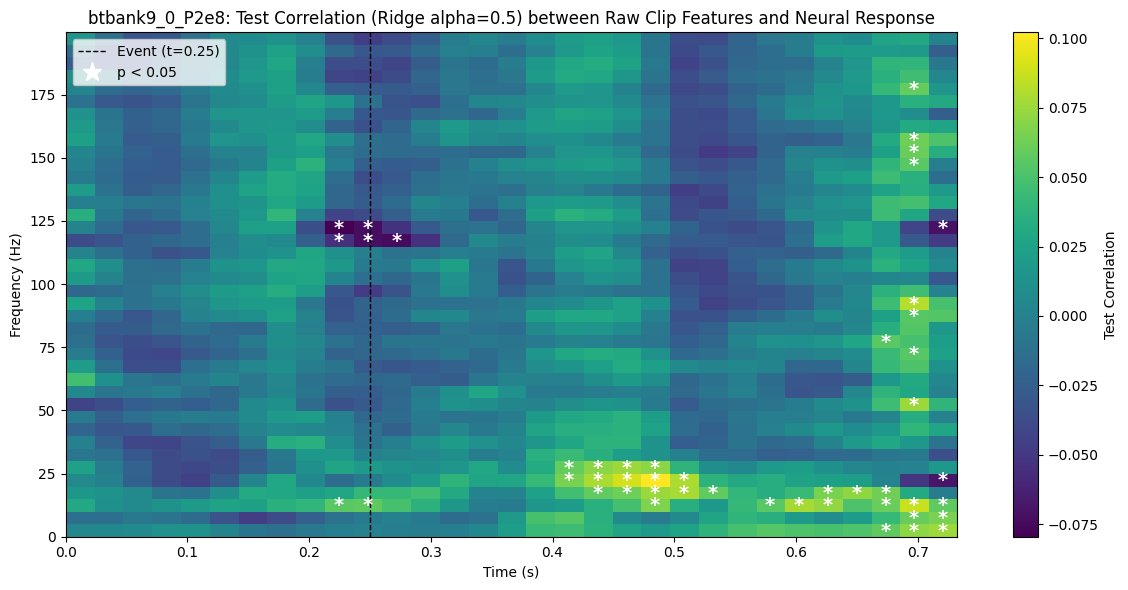


=== Results for Ridge alpha=1.0 ===


Timebin (alpha=1.0): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:21<00:00,  6.49s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.01071004  0.01054389  0.01101946 ...  0.05780297  0.07096354
   0.07515543]
 [-0.01017396 -0.01232232 -0.00666263 ...  0.04177143  0.05878706
   0.06385709]
 [ 0.03230854  0.01478657  0.01276693 ...  0.07110486  0.09656299
   0.06420231]
 ...
 [-0.02776469 -0.0360223  -0.03443771 ...  0.04156263  0.04230436
  -0.00541629]
 [-0.01214245 -0.0405725  -0.03631704 ...  0.01829693  0.01707273
  -0.02831781]
 [ 0.01407594 -0.01072392 -0.03089126 ...  0.02449589  0.03194363
   0.00249975]]
Test P-value Matrix (shape (40, 31)):
[[7.00419982e-01 7.04848160e-01 6.92200861e-01 ... 3.76886790e-02
  1.06959289e-02 6.85777654e-03]
 [7.14742666e-01 6.57998501e-01 8.10835891e-01 ... 1.33295408e-01
  3.45437319e-02 2.16578272e-02]
 [2.45666287e-01 5.95269963e-01 6.46484147e-01 ... 1.05404753e-02
  5.07036138e-04 2.09571330e-02]
 ...
 [3.18474372e-01 1.95503705e-01 2.15904831e-01 ... 1.35248341e-01
  1.28409796e-01 8.45726650e-01]
 [6.62680275e-01 1.44810853

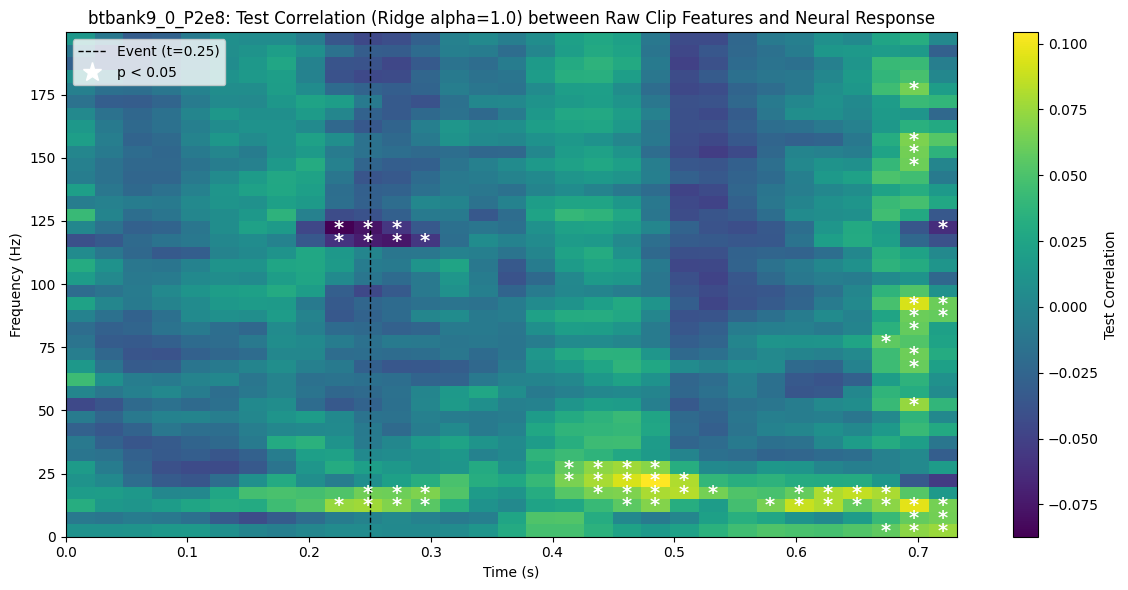


=== Results for Ridge alpha=10.0 ===


Timebin (alpha=10.0): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [03:47<00:00,  7.33s/it]


Test Correlation Matrix (shape (40, 31)):
[[ 0.01459416  0.01153998  0.00652138 ...  0.04961374  0.05880525
   0.05979693]
 [-0.00980736 -0.02024879 -0.02202006 ...  0.02987796  0.04012473
   0.04017866]
 [ 0.04503698  0.03009917  0.03460146 ...  0.13649475  0.15631463
   0.12879335]
 ...
 [-0.02943573 -0.03252402 -0.02500528 ...  0.06246875  0.06235176
   0.02169574]
 [-0.02230308 -0.03582642 -0.02600393 ...  0.02253844  0.02384462
  -0.0250869 ]
 [ 0.00813529 -0.00529149 -0.01892056 ...  0.02617483  0.03938607
   0.00640393]]
Test P-value Matrix (shape (40, 31)):
[[6.00068838e-01 6.78456278e-01 8.14772653e-01 ... 7.45213645e-02
  3.44877600e-02 3.15519597e-02]
 [7.24595723e-01 4.66930402e-01 4.28865722e-01 ... 2.83019279e-01
  1.49301570e-01 1.48755161e-01]
 [1.05509932e-01 2.79468760e-01 2.13728206e-01 ... 8.37383436e-07
  1.60317818e-08 3.38311568e-06]
 ...
 [2.90208374e-01 2.42529833e-01 3.68962504e-01 ... 2.46852979e-02
  2.49563946e-02 4.35697487e-01]
 [4.22955109e-01 1.97946290

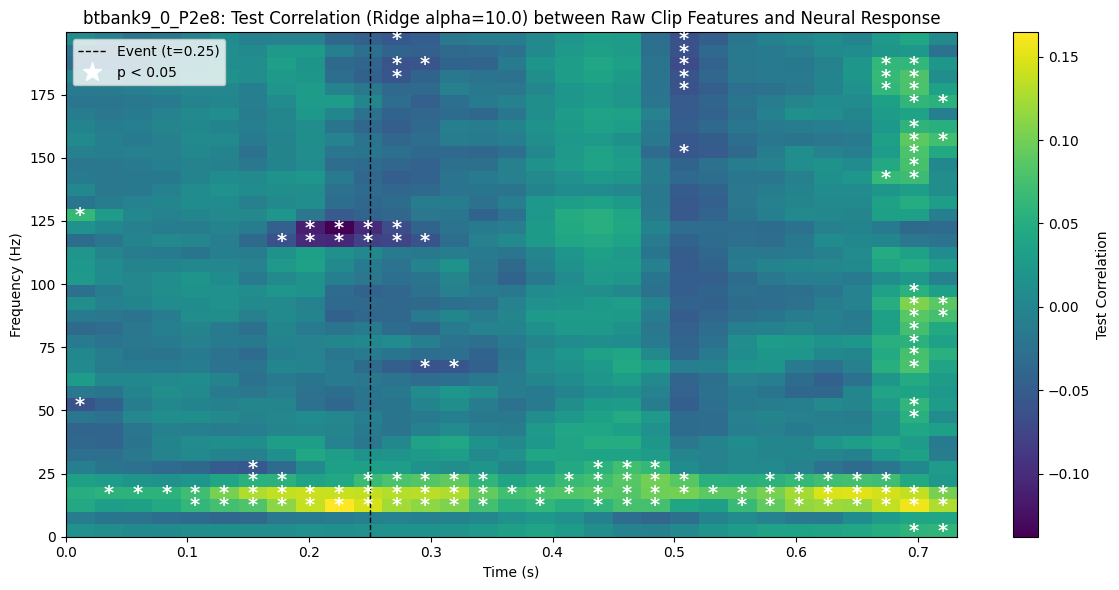

In [30]:
n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

n_samples = X.shape[0]
# train_idx, test_idx = train_test_split(np.arange(n_samples), test_size=0.2, random_state=42)

alpha_values = [0.05, 0.1, 0.5, 1.0, 10.0]

for alpha in alpha_values:
    print(f"\n=== Results for Ridge alpha={alpha} ===")
    correlation_matrix = np.zeros((n_freqs, n_timebins))
    test_correlation_matrix = np.zeros((n_freqs, n_timebins))
    test_pval_matrix = np.zeros((n_freqs, n_timebins))

    for t in tqdm(range(n_timebins), desc=f"Timebin (alpha={alpha})"):
        for f in range(n_freqs):
            # Get the neural response for all samples at this (t, f)
            y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_vals[train_idx], y_vals[test_idx]
            reg = Ridge(alpha=alpha)
            reg.fit(X_train, y_train)
            y_pred_test = reg.predict(X_test)
            corr, pval = pearsonr(y_test, y_pred_test)
            test_correlation_matrix[f, t] = corr
            test_pval_matrix[f, t] = pval

    print("Test Correlation Matrix (shape {}):".format(test_correlation_matrix.shape))
    print(test_correlation_matrix)
    print("Test P-value Matrix (shape {}):".format(test_pval_matrix.shape))
    print(test_pval_matrix)

    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        test_correlation_matrix,
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[
            time_bins[0],
            time_bins[-1],
            freq_bins[0],
            freq_bins[-1]
        ]
    )

    star_y, star_x = np.where(test_pval_matrix < 0.05)

    time_edges = np.linspace(
        time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
        time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
        test_correlation_matrix.shape[1] + 1
    )
    freq_edges = np.linspace(
        freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
        freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
        test_correlation_matrix.shape[0] + 1
    )
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

    for y, x in zip(star_y, star_x):
        plt.text(
            time_centers[x], freq_centers[y], '*',
            color='white', fontsize=14, ha='center', va='center', fontweight='bold'
        )

    event_time = 0.25
    event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
    asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

    plt.colorbar(im, label='Test Correlation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge alpha={alpha}) between Raw Clip Features and Neural Response')
    plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()


Timebin (Fold 1/3):   0%|                                                                                                                             | 0/31 [00:00<?, ?it/s]

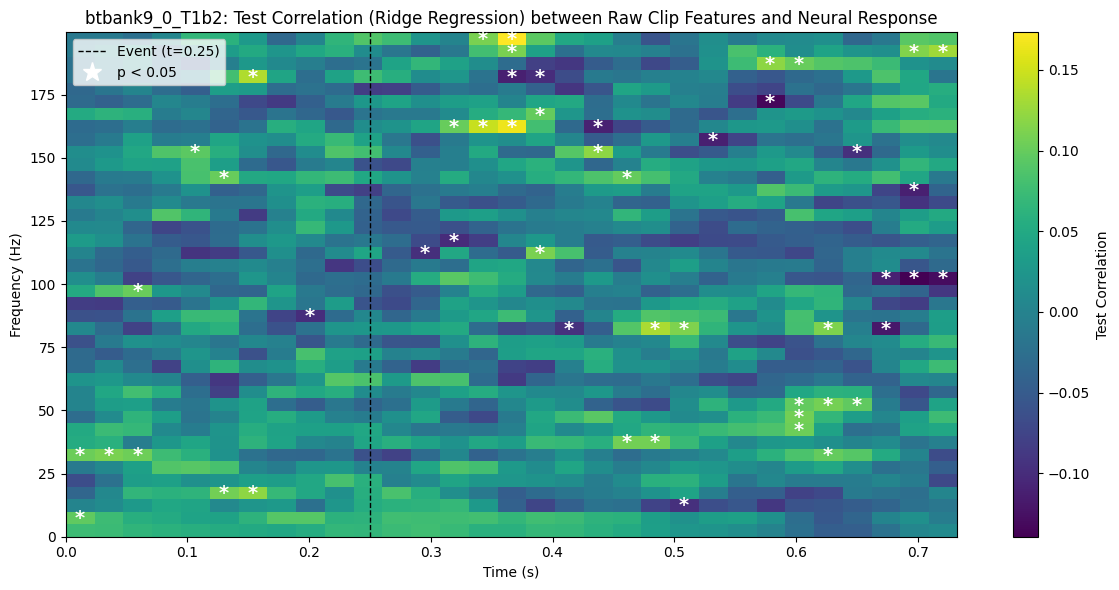

In [42]:
from sklearn.preprocessing import StandardScaler

n_timebins = y_spectrogram.shape[2]
n_freqs = y_spectrogram.shape[3]

n_samples = X.shape[0]
n_folds = 3

fold_size = n_samples // n_folds
fold_indices = [i * fold_size for i in range(n_folds)] + [n_samples]

# Store correlation and pval matrices for each fold
fold_correlation_matrices = []
fold_pval_matrices = []

for fold in range(n_folds):
    fold_corr_matrix = np.zeros((n_freqs, n_timebins))
    fold_pval_matrix = np.zeros((n_freqs, n_timebins))
    # Chronological split: train on all but the current fold, test on the current fold
    test_start = fold_indices[fold]
    test_end = fold_indices[fold + 1]
    test_idx = np.arange(test_start, test_end)
    train_idx = np.concatenate([
        np.arange(0, test_start),
        np.arange(test_end, n_samples)
    ]) if n_folds > 1 else np.arange(0, test_start)  # For n_folds=1, just use all before test

    X_train, X_test = X[train_idx], X[test_idx]

    # Normalize features using StandardScaler (fit on train, transform both train and test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for t in tqdm(range(n_timebins), desc=f"Timebin (Fold {fold+1}/{n_folds})", leave=False):
        for f in range(n_freqs):
            y_vals = y_spectrogram[:, 0, t, f].cpu().numpy() if hasattr(y_spectrogram, 'cpu') else y_spectrogram[:, 0, t, f]
            y_train, y_test = y_vals[train_idx], y_vals[test_idx]
            if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
                # Not enough variance to compute correlation
                fold_corr_matrix[f, t] = np.nan
                fold_pval_matrix[f, t] = np.nan
                continue
            reg = Ridge(alpha=0.1)
            reg.fit(X_train_scaled, y_train)
            y_pred_test = reg.predict(X_test_scaled)
            corr, pval = pearsonr(y_test, y_pred_test)
            fold_corr_matrix[f, t] = corr
            fold_pval_matrix[f, t] = pval

    fold_correlation_matrices.append(fold_corr_matrix)
    fold_pval_matrices.append(fold_pval_matrix)

# Find the fold with the highest sum of absolute correlation values
fold_sums = [np.nansum(np.abs(mat)) for mat in fold_correlation_matrices]
best_fold_idx = np.argmax(fold_sums)

test_correlation_matrix = fold_correlation_matrices[best_fold_idx]
test_pval_matrix = fold_pval_matrices[best_fold_idx]

plt.figure(figsize=(12, 6))
im = plt.imshow(
    test_correlation_matrix,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[
        time_bins[0],
        time_bins[-1],
        freq_bins[0],
        freq_bins[-1]
    ]
)

star_y, star_x = np.where(test_pval_matrix < 0.05)

time_edges = np.linspace(
    time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
    time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
    test_correlation_matrix.shape[1] + 1
)
freq_edges = np.linspace(
    freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
    freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
    test_correlation_matrix.shape[0] + 1
)
time_centers = (time_edges[:-1] + time_edges[1:]) / 2
freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

for y, x in zip(star_y, star_x):
    plt.text(
        time_centers[x], freq_centers[y], '*',
        color='white', fontsize=14, ha='center', va='center', fontweight='bold'
    )

event_time = 0.25
event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

plt.colorbar(im, label='Test Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response')
plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


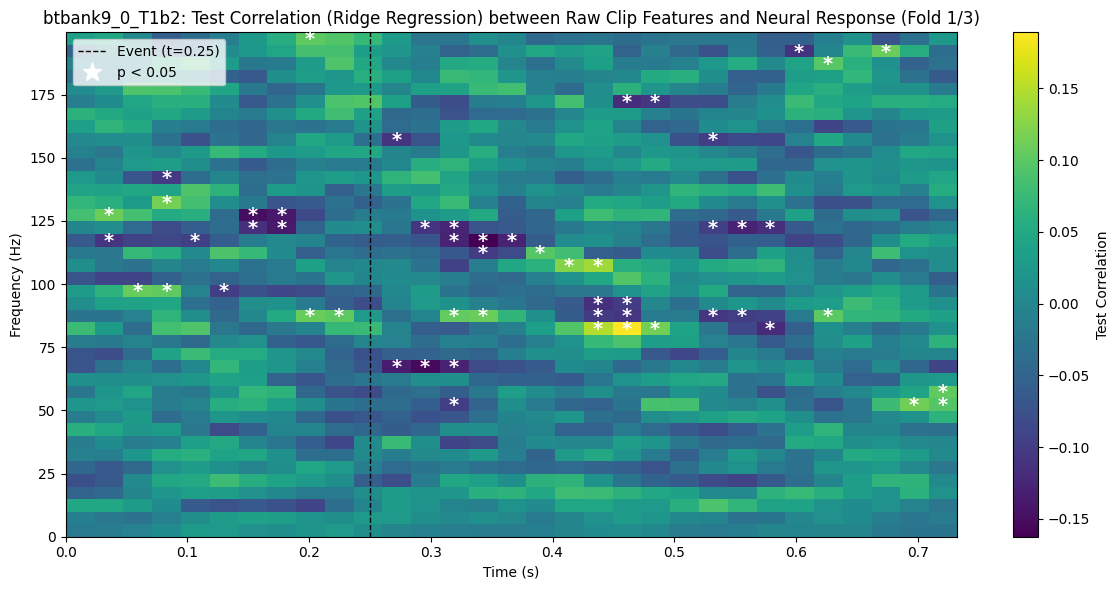

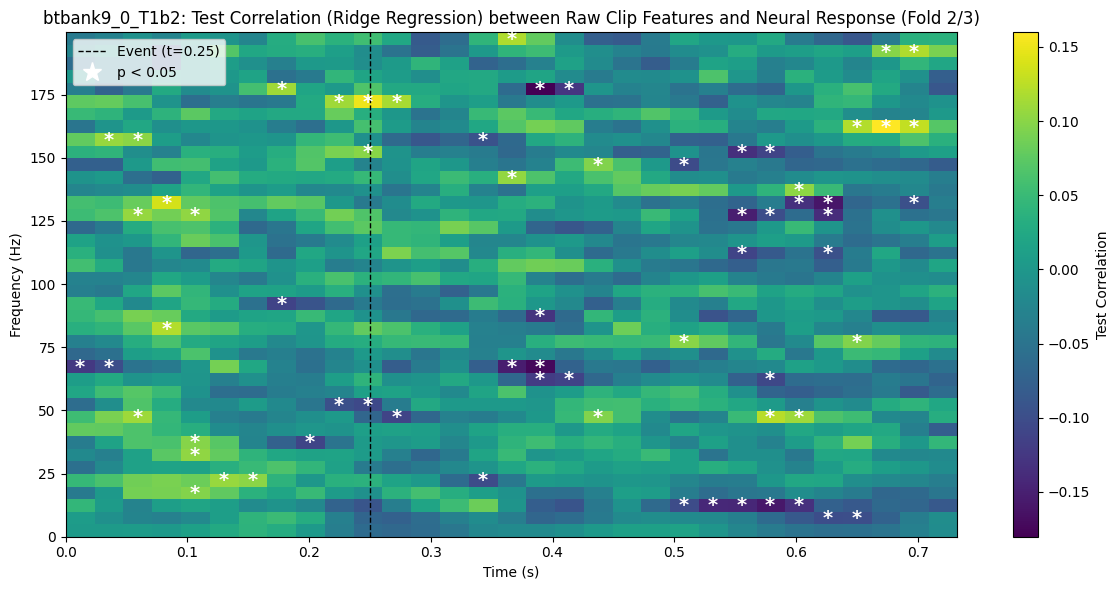

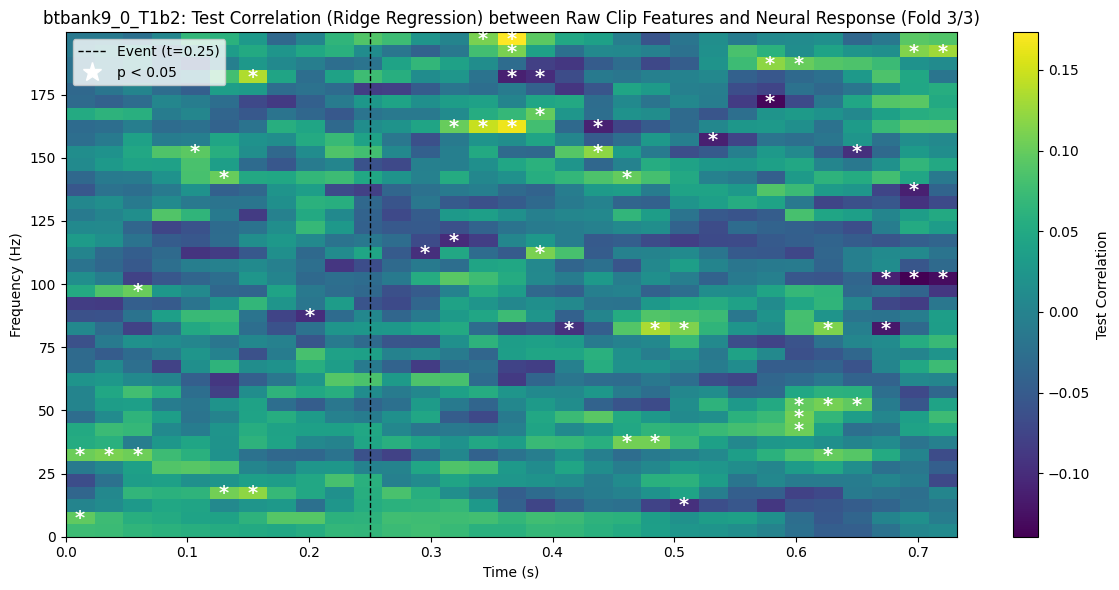

In [43]:
n_folds = len(fold_correlation_matrices)
for fold_idx in range(n_folds):
    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        fold_correlation_matrices[fold_idx],
        aspect='auto',
        origin='lower',
        cmap='viridis',
        extent=[
            time_bins[0],
            time_bins[-1],
            freq_bins[0],
            freq_bins[-1]
        ]
    )

    star_y, star_x = np.where(fold_pval_matrices[fold_idx] < 0.05)

    time_edges = np.linspace(
        time_bins[0].item() if hasattr(time_bins[0], 'item') else time_bins[0],
        time_bins[-1].item() if hasattr(time_bins[-1], 'item') else time_bins[-1],
        fold_correlation_matrices[fold_idx].shape[1] + 1
    )
    freq_edges = np.linspace(
        freq_bins[0].item() if hasattr(freq_bins[0], 'item') else freq_bins[0],
        freq_bins[-1].item() if hasattr(freq_bins[-1], 'item') else freq_bins[-1],
        fold_correlation_matrices[fold_idx].shape[0] + 1
    )
    time_centers = (time_edges[:-1] + time_edges[1:]) / 2
    freq_centers = (freq_edges[:-1] + freq_edges[1:]) / 2 - 0.3

    for y, x in zip(star_y, star_x):
        plt.text(
            time_centers[x], freq_centers[y], '*',
            color='white', fontsize=14, ha='center', va='center', fontweight='bold'
        )

    event_time = 0.25
    event_line = plt.axvline(event_time, color='black', linestyle='--', linewidth=1, label='Event (t=0.25)')
    asterisk_handle = Line2D([0], [0], marker='*', color='w', linestyle='None', markersize=14, markerfacecolor='w', label='p < 0.05')

    plt.colorbar(im, label='Test Correlation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'btbank{subject_id}_{trial_id}_{electrode_label}: Test Correlation (Ridge Regression) between Raw Clip Features and Neural Response (Fold {fold_idx+1}/{n_folds})')
    plt.legend(handles=[event_line, asterisk_handle], loc='upper left', frameon=True)
    plt.tight_layout()
    plt.show()
